<a href="https://colab.research.google.com/github/jwlw2022/nlp-chatbot-project/blob/main/6864_NLP_Chatbot_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
# %%bash
# Logistics #2: install the transformers package, create a folder, download the dataset and a patch
!pip install pytorch-pretrained-bert
!pip -q install transformers
!pip -q install datasets
!pip -q install tqdm
!pip -q install sentencepiece 

     |████████████████████████████████| 133kB 14.6MB/s 
     |████████████████████████████████| 133kB 19.5MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 7.5MB 20.9MB/s 
ERROR: botocore 1.20.72 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 2.3MB 15.4MB/s 
     |████████████████████████████████| 901kB 49.1MB/s 
     |████████████████████████████████| 3.3MB 54.4MB/s 
     |████████████████████████████████| 225kB 13.9MB/s 
     |████████████████████████████████| 245kB 24.7MB/s 
     |████████████████████████████████| 112kB 26.6MB/s 
     |████████████████████████████████| 1.2MB 15.5MB/s 


# Pretrained tokenizer

In [2]:
# import transformers

# Use a pretrained tokenizer with CLASS.from_pretrained() function
# tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-cased')

# Download PersonaChat dataset


In [3]:
import json
from pytorch_pretrained_bert import cached_path

url = "https://s3.amazonaws.com/datasets.huggingface.co/personachat/personachat_self_original.json"

# Download and load JSON dataset
personachat_file = cached_path(url)
with open(personachat_file, "r", encoding="utf-8") as f:
    dataset = json.loads(f.read())

100%|██████████| 209850483/209850483 [00:08<00:00, 24717712.17B/s]


In [4]:
for i in range(5):
    print('Dialogue ', i)
    # print('Persona: ')
    # for persona in dataset['train'][i]['personality']:
    #     print(persona)
    print('Utterances: ')
    for dialogue in dataset['train'][i]['utterances']:
        print(dialogue['history'][-1])

Dialogue  0
Utterances: 
hi , how are you doing ? i'm getting ready to do some cheetah chasing to stay in shape .
i am ! for my hobby i like to do canning or some whittling .
that's neat . when i was in high school i placed 6th in 100m dash !
i do not . but i do have a favorite meat since that is all i eat exclusively .
i would have to say its prime rib . do you have any favorite foods ?
do you have anything planned for today ? i think i am going to do some canning .
i think i will can some jam . do you also play footfall for fun ?
Dialogue  1
Utterances: 
hi , how are you doing today ?
wow , four sisters . just watching game of thrones .
i agree . what do you do for a living ?
interesting . i'm a website designer . pretty much spend all my time on the computer .
that's awesome . i have always had a love for technology .
i really enjoy free diving , how about you , have any hobbies ?
that's nice . moms are pretty cool too .
Dialogue  2
Utterances: 
we all live in a yellow submarine , a

In [5]:
def tokenize(dataset):
    train_tokens = []
    for i in range(len(dataset['train'])):  # dialogues
        for dialogue in dataset['train'][i]['utterances']:
            tokens = dialogue['history'][-1].split(' ')
            train_tokens.append(tokens)
    
    valid_tokens = []
    for i in range(len(dataset['valid'])):  # dialogues
        for dialogue in dataset['valid'][i]['utterances']:
            tokens = dialogue['history'][-1].split(' ')
            valid_tokens.append(tokens)

    train_source = []
    train_target = []
    for i in range(len(train_tokens)-2):
        copy = train_tokens[i].copy()
        copy.extend(['|'])
        copy.extend(train_tokens[i+1])
        train_source.append(copy)
        train_target.append(train_tokens[i+2])

    valid_source = []
    valid_target = []
    for i in range(len(valid_tokens)-2):
        copy = valid_tokens[i].copy()
        copy.extend(['|'])
        copy.extend(valid_tokens[i+1])
        valid_source.append(copy)
        valid_target.append(valid_tokens[i+2])

    return train_source, train_target, valid_source, valid_target

print(len(dataset['train']))
train_source, train_target, valid_source, valid_target = tokenize(dataset)
print(train_source[0])
print(len(train_source))
print(len(train_target))
print(len(valid_source))
print(len(valid_target))
# print(train_target)
# print(valid_source)
# print(valid_target)

17878
['hi', ',', 'how', 'are', 'you', 'doing', '?', "i'm", 'getting', 'ready', 'to', 'do', 'some', 'cheetah', 'chasing', 'to', 'stay', 'in', 'shape', '.', '|', 'i', 'am', '!', 'for', 'my', 'hobby', 'i', 'like', 'to', 'do', 'canning', 'or', 'some', 'whittling', '.']
131436
131436
7799
7799


In [6]:
# a = max(list(map(len, train_source)))
# print(a)

a = max([len(x) for x in train_source])
print(a)

119


In [7]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim

# Seq2Seq Code

## Download Dataset

In [8]:
from google.colab import drive 
drive.mount("/content/drive")

MODEL_FOLDER = "/content/drive/My Drive/mit-6864/hw3"
!mkdir -p "/content/drive/My Drive/mit-6864/hw3"

Mounted at /content/drive


In [9]:
%%bash
git clone https://github.com/mit-6864/hw3.git
mkdir -p /content/hw3/data

pip install sacrebleu

Cloning into 'hw3'...


In [10]:
# Download data
DATA_DIR = "/content/hw3/data"

# !wget -nv -O "$DATA_DIR/train.en" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
# !wget -nv -O "$DATA_DIR/train.vi" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget -nv -O "$DATA_DIR/vocab.en" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
# !wget -nv -O "$DATA_DIR/vocab.vi" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi

2021-05-12 20:33:10 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en [139741/139741] -> "/content/hw3/data/vocab.en" [1]


In [11]:
words = set()
for sentence in train_source:
  words.update(sentence)
for sentence in train_target:
  words.update(sentence)
for sentence in valid_source:
  words.update(sentence)
for sentence in valid_target:
  words.update(sentence)
print(len(words))
with open('/content/hw3/data/vocab.txt', 'w') as writefile:
    writefile.write('\n'.join(words))

18597


Number of training (src, trg) sentence pairs: 118280
Number of validation (src, trg) sentence pairs: 13142
Number of testing (src, trg) sentence pairs: 7799
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 18598
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 18598
Training sentence avg. length: 22 
Training sentence length at 95-percentile: 34
Training sentence length distribution (x-axis is length range and y-axis is count):



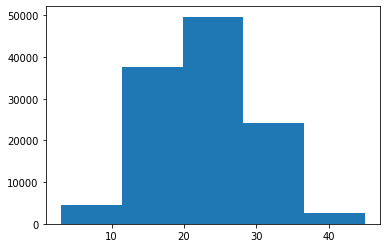

Example Vietnamese input: ['that', 'is', 'great', '.', 'keep', 'up', 'with', 'news', 'plus', 'stay', 'in', 'shape', '|', 'hi', '.', 'sorry', 'in', 'advance', 'my', 'english', 'is', 'not', 'that', 'great', '.']
Its target English output: ["i'm", 'okay', '.', 'i', 'just', 'took', 'my', 'dog', 'for', 'a', 'walk', '.', 'you', '?']


In [24]:
import sys
sys.path.append("/content/hw3")

import lab_utils

import torch 
# !pip install torch==1.6.0 torchvision==0.7.0
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
from lab_utils import read_vocab_file, read_sentence_file, filter_data, show_some_data_stats

# src_vocab_set = read_vocab_file("vocab.vi")
# trg_vocab_set = read_vocab_file("vocab.en")
trg_vocab_set = list(words)
src_vocab_set = trg_vocab_set

train_src_sentences_list = train_source
train_trg_sentences_list = train_target
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

# test_src_sentences_list = read_sentence_file("tst2013.vi")
# test_trg_sentences_list = read_sentence_file("tst2013.en")
test_src_sentences_list = valid_source
test_trg_sentences_list = valid_target
assert len(test_src_sentences_list) == len(test_trg_sentences_list)

# Filter out sentences over 48 words long
MAX_SENT_LENGTH = 45
MAX_SENT_LENGTH_PLUS_SOS_EOS = 46

train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, train_trg_sentences_list, MAX_SENT_LENGTH)
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, test_trg_sentences_list, MAX_SENT_LENGTH)

# We take 10% of training data as validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

show_some_data_stats(train_src_sentences_list, val_src_sentences_list, 
                     test_src_sentences_list, train_trg_sentences_list,
                     src_vocab_set, trg_vocab_set)

In [25]:
import torch
from torch.utils import data

# These IDs are reserved.
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3


class MTDataset(data.Dataset):
  def __init__(self, src_sentences, src_vocabs, trg_sentences, trg_vocabs,
               sampling=1.):
    self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
    self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]

    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
    self.max_trg_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

    self.src_vocabs = src_vocabs
    self.trg_vocabs = trg_vocabs

    self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
    self.src_id2v = {val : key for key, val in self.src_v2id.items()}
    self.trg_v2id = {v : i for i, v in enumerate(trg_vocabs)}
    self.trg_id2v = {val : key for key, val in self.trg_v2id.items()}

  def __len__(self):
    return len(self.src_sentences)

  def __getitem__(self, index):
    src_sent = self.src_sentences[index]
    src_len = len(src_sent) + 1
    src_id = []
    for w in src_sent:
      if w == '|':
        # src_id.append(EOS_INDEX)
        # src_id.append(SOS_INDEX)
        pass
      else:
        if w not in self.src_vocabs:
          w = '<unk>'
        src_id.append(self.src_v2id[w])
    src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
               (self.max_src_seq_length - src_len))
    #src_id = (src_id + [PAD_INDEX] * (self.max_src_seq_length - src_len))

    trg_sent = self.trg_sentences[index]
    trg_len = len(trg_sent) + 2
    trg_id = []
    for w in trg_sent:
      if w not in self.trg_vocabs:
        w = '<unk>'
      trg_id.append(self.trg_v2id[w])
    trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
               (self.max_trg_seq_length - trg_len))
    #trg_id = (trg_id + [PAD_INDEX] * (self.max_trg_seq_length - trg_len))

    return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len

## Encoder

In [26]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.):
    """
    Inputs: 
      - `input_size`: an int representing the RNN input size.
      - `hidden_size`: an int representing the RNN hidden size.
      - `dropout`: a float representing the dropout rate during training. Note
          that for 1-layer RNN this has no effect since dropout only applies to
          outputs of intermediate layers.
    """
    
    super(Encoder, self).__init__()

    # --------- Your code here --------- #
    # feel free to use a pre-implemented pytorch GRU
    # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    self.rnn = nn.GRU(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=3,
                      batch_first=True,
                      dropout=dropout)
    
    # --------- Your code ends --------- #

  def forward(self, inputs, lengths):
    """
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of source
          sentences.
      - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence
          lengths of `inputs`.

    Returns:
      - `outputs`: a 3d-tensor of shape
        (batch_size, max_seq_length, hidden_size).
      - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).

      Hint: `outputs` and `finals` are both standard GRU outputs.
    """
    outputs = None
    finals = None
    
    # --------- Your code here --------- #
    # hint: you probably want to pack the inputs and outputs (see note below)
    #       https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html
    # hint2: given the shape of the inputs and outputs, 
    #        it might be helpful to specify batch_first=True (also in __init___)
    # hint3: MAX_SENT_LENGTH_PLUS_SOS_EOS is a global variable that exists if 
    #        you ever need to specify a total_length for outputs

    packed_sequence = pack_padded_sequence(inputs,
                                           lengths.cpu(),
                                           batch_first=True,
                                           enforce_sorted=False)
    outputs, finals = self.rnn(packed_sequence)
    outputs, _ = pad_packed_sequence(outputs, batch_first=True)
    
    # --------- Your code ends --------- #

    return outputs, finals

## Decoder

In [27]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(Decoder, self).__init__()

    # --------- Your code here --------- #
    # hint: you need more layers than the encoder
    #       again, feel free to use pytorch implemetnations
    #       https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
    
    # To initialize from the final encoder state.

    self.rnn = nn.GRU(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=3,
                      batch_first=True,
                      dropout=dropout)

    self.bridge = nn.Linear(hidden_size, input_size, bias=True)

    # --------- Your code ends --------- #

  def forward_step(self, prev_embed, hidden):
    """Helper function for forward below:
       Perform a single decoder step (1 word).

       Inputs:
      - `prev_embed`: a 3d-tensor of shape (batch_size, 1, embed_size)
          representing the padded embedded word vectors at this step in training
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the current hidden state.

      Returns:
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the current decoder hidden state.
      - `pre_output`: a 3d-tensor of shape (batch_size, 1, hidden_size)
          representing the total decoder output for one step
    """
    pre_output = None
    # --------- Your code here --------- #
    
    pre_output, hidden = self.rnn(prev_embed, hidden)

    # --------- Your code ends --------- #
    return hidden, pre_output

  def forward(self, inputs, encoder_finals, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.

    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
          We will convert it later in a `Generator` below.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the last decoder hidden state.
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    outputs = []
    
    # --------- Your code here --------- #

    # Unroll the decoder RNN for `max_len` steps.
    # hint: use the above helper function forward_step that 
    #       performs a single decoder step (1 word).

    for i in range(max_len):
        prev_embed = inputs[:, i:i+1, :] # get embeddings from inputs
        hidden, pre_output = self.forward_step(prev_embed, hidden)
        outputs.append(pre_output)
    
    # final output concatenates outputs for each word
    outputs = torch.cat(outputs, dim=1)

    # --------- Your code ends --------- #

    return hidden, outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    decoder_init_hiddens = torch.tanh(self.bridge(encoder_finals))

    return decoder_init_hiddens

## EncoderDecoder

In [28]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: a `Decoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    del encoder_hiddens   # unused
    return self.decode(encoder_finals, trg_ids[:, :-1])

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)

## Generator

In [29]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

## Training loop

In [30]:
from torch.utils import data

batch_size = 128

# You can try on a smaller training set by setting a smaller `sampling`.
train_set = MTDataset(train_src_sentences_list, src_vocab_set,
                      train_trg_sentences_list, trg_vocab_set, sampling=1.)
# print('TRAIN')
# for i in range(len(train_set)):
#   if len(train_set[i][0]) != 48 or len(train_set[i][2]) != 48:
#     print(train_set[i])
#     break
# print(len(train_set))
# print(train_set[0])
# print(len(train_set[0][0])) # source
# print(len(train_set[0][2])) # target
# print(train_set[126])
# print(len(train_set[126][0])) # source
# print(len(train_set[126][2])) # target
train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                    num_workers=8, shuffle=True)

val_set = MTDataset(val_src_sentences_list, src_vocab_set,
                    val_trg_sentences_list, trg_vocab_set, sampling=1.)
# print('VAL')
# for i in range(len(val_set)):
#   if len(val_set[i][0]) != 48 or len(val_set[i][2]) != 48:
#     print(val_set[i])
#     break
val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=8,
                                  shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [31]:
import math


class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()          
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)

    del trg_lengths_B   # unused

    _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)

    loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                        norm=src_ids_BxT.size(0))
    total_loss += loss
    total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

  return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, print_every):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  dev_ppls = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)

    model.train()
    train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim),
                          print_every=print_every)
        
    model.eval()
    with torch.no_grad():      
      dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None),
                          print_every=print_every)
      print("Validation perplexity: %f" % dev_ppl)
      dev_ppls.append(dev_ppl)
        
  return dev_ppls

Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch Step: 0 Loss: 115.288734
Epoch Step: 100 Loss: 70.040306
Epoch Step: 200 Loss: 68.361130
Epoch Step: 300 Loss: 59.927689
Epoch Step: 400 Loss: 57.736328
Epoch Step: 500 Loss: 49.946785
Epoch Step: 600 Loss: 50.618969
Epoch Step: 700 Loss: 52.062267
Epoch Step: 800 Loss: 52.103497
Epoch Step: 900 Loss: 54.552235
Validation perplexity: 69.957525
Epoch 1
Epoch Step: 0 Loss: 50.077312
Epoch Step: 100 Loss: 52.202248
Epoch Step: 200 Loss: 48.450439
Epoch Step: 300 Loss: 45.890629
Epoch Step: 400 Loss: 46.830956
Epoch Step: 500 Loss: 46.588886
Epoch Step: 600 Loss: 46.330894
Epoch Step: 700 Loss: 46.684837
Epoch Step: 800 Loss: 44.182678
Epoch Step: 900 Loss: 42.509033
Validation perplexity: 49.814913
Epoch 2
Epoch Step: 0 Loss: 45.457096
Epoch Step: 100 Loss: 46.547241
Epoch Step: 200 Loss: 43.050648
Epoch Step: 300 Loss: 45.277775
Epoch Step: 400 Loss: 40.396210
Epoch Step: 500 Loss: 45.367744
Epoch Step: 600 Loss: 45.199005
Epoch Step: 700 Loss: 43.944557
Epoch Step: 800 Loss: 42.44

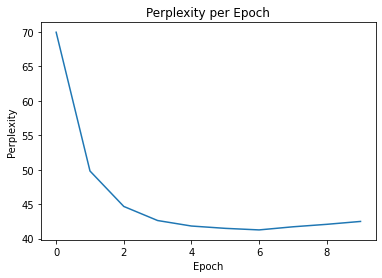

In [33]:
device = 'cuda'

# Hyperparameters for contructing the encoder-decoder model.
embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256  # RNN hidden size.
dropout = 0.2

pure_seq2seq = EncoderDecoder(
    encoder=Encoder(embed_size, hidden_size, dropout=dropout),
    decoder=Decoder(embed_size, hidden_size, dropout=dropout),
    src_embed=nn.Embedding(len(src_vocab_set), embed_size),
    trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
    generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

train_model = True
if train_model:
  # Start training. The returned `dev_ppls` is a list of dev perplexity for each
  # epoch.
  pure_dev_ppls = train(pure_seq2seq, num_epochs=10, learning_rate=1e-3,
                        print_every=100)
  
  torch.save(pure_seq2seq.state_dict(), MODEL_FOLDER+"/" + "pure_seq2seq.pt")

  # Plot perplexity
  lab_utils.plot_perplexity(pure_dev_ppls)
else:
  pure_seq2seq.load_state_dict(torch.load(MODEL_FOLDER+"/" + "pure_seq2seq.pt"))

In [ ]:
def greedy_decode(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderDecoder. Make sure to chop off the 
     EOS token!"""

  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None
  
  # --------- Your code here --------- #

  for i in range(max_len):
      with torch.no_grad():
          hidden, out = model.decode(encoder_finals, prev_y, hidden)
          output.append(torch.argmax(model.generator(out)))
          prev_y[0][0] = output[-1]

          if output[-1] == EOS_INDEX:
              output = output[:-1]
              break

  # --------- Your code ends --------- #

  return output

In [ ]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(example_set, batch_size=1, num_workers=1,
                                      shuffle=False)


print("EncoderDecoder Results:")
lab_utils.print_examples(pure_seq2seq, src_vocab_set, trg_vocab_set,
                         example_data_loader, greedy_decode, n=10)

# ATTENTION
Source code: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training Attention Encoder-Decoder Model

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Plotting results

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

## Visualizing Attention

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")